## Image Classification task on **CIFAR-10 dataset**

It contains 60,000 32x32 RGB images of 10 different classes (50,000 for training and 10,000 for testing)

Citation: Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.

In [13]:
LOG_ROOT = 'tensorboard_logs'
USE_GPU = False

In [14]:
%matplotlib inline
import os
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import urllib

# Image plotting function
def plot_multiple(images, titles=None, colormap='gray',
                  max_columns=np.inf, imwidth=2, imheight=2, share_axes=False):
    """
    Plot multiple images as subplots on a grid. Images must be channel-first
    and between [0, 1].
    """
    images = [np.transpose(im, (1, 2, 0)) for im in images]
    if titles is None:
        titles = [''] * len(images)
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * imwidth, n_rows * imheight),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    fig.tight_layout()
    
def visualize_dataset(dataset, n_samples=24, max_columns=6):
    xs, ys = list(zip(*[dataset[i] for i in range(n_samples)]))
    plot_multiple([x / 2 + 0.5 for x in xs], [labels[i] for i in ys], max_columns=max_columns)

Files already downloaded and verified
Files already downloaded and verified

Shape of an image: torch.Size([3, 32, 32]).


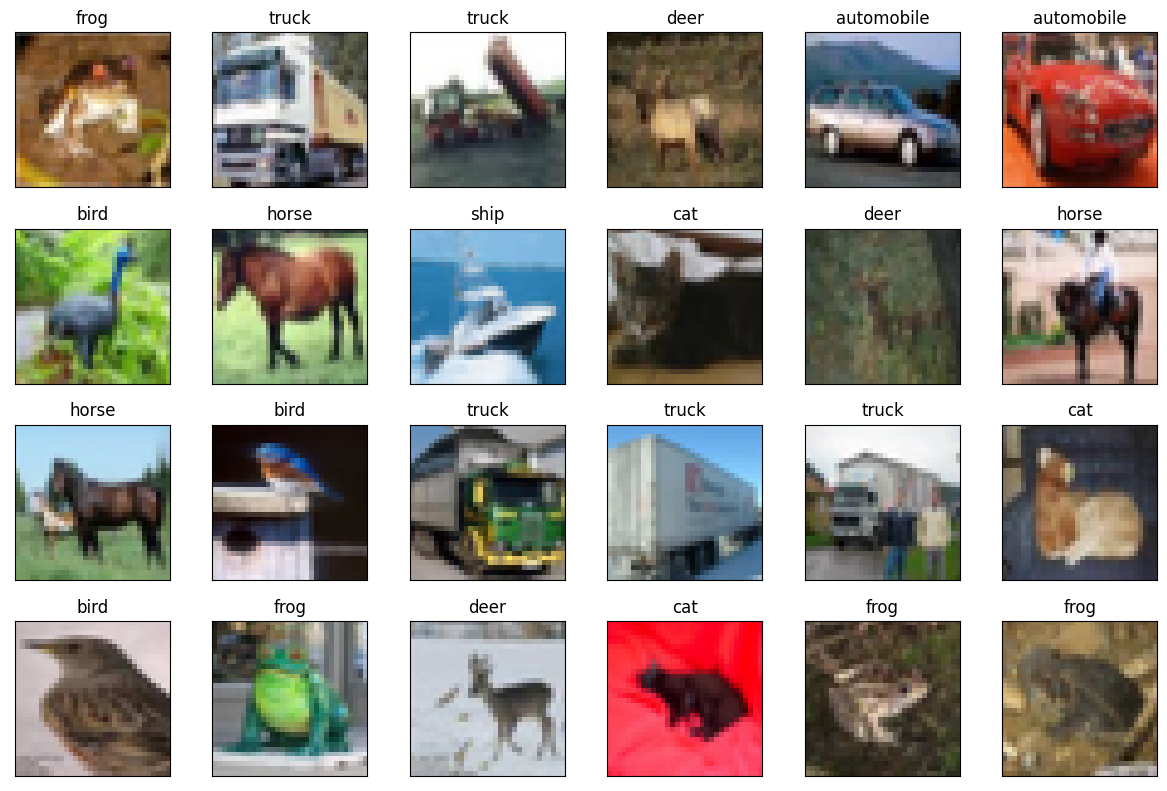

In [15]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
urllib.request.urlopen("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz").read()
normalize_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_data = CIFAR10(root='cifar10/train/', train=True, download=True, transform=normalize_transform)
test_data = CIFAR10(root='cifar10/test/', train=False, download=True, transform=normalize_transform)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

x, y = train_data[0]  # get an example from the dataset
print(f'\nShape of an image: {x.shape}.')
visualize_dataset(train_data)

**Defining a general Classifier**

In [16]:
def train_classifier(model,
                     opt,
                     logdir,
                     train_data=train_data,
                     test_data=test_data,
                     batch_size=128,
                     n_epochs=50,
                     lr_scheduler=None
                    ):
    
    writer = SummaryWriter(f"{LOG_ROOT}/{logdir}-{time.strftime('%y%m%d_%H%M%S')}")
    layout = {
        'Losses': {'losses': ['Multiline', ['loss/train', 'loss/test']]},
        'Accuracy': {'accuracy': ['Multiline', ['accuracy/train', 'accuracy/test']]}
    }
    writer.add_custom_scalars(layout)
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=6)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=6)
    
    criterion = nn.CrossEntropyLoss()
    
    start = time.time()
    
    for epoch in range(n_epochs):
        sample_count = 0
        loss_sum = 0
        correct = 0
        n_batches = len(train_loader)
        model.train()
        for i, (xs, ys) in enumerate(train_loader):
            if USE_GPU:
                xs = xs.cuda()
                ys = ys.cuda()
            out = model(xs)
            loss = criterion(out, ys)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            loss_sum += loss.item() * xs.shape[0]
            _, pred = torch.max(out, 1)
            correct += (pred == ys).sum().item()
            sample_count += xs.shape[0]
            print(f'Train epoch {epoch+1}, step {i+1}/{n_batches}', end='    \r')

        train_loss = loss_sum / sample_count
        train_accuracy = correct / sample_count
        
        with torch.no_grad():  # Not storing gradients during testing, decreases memory consumption
            sample_count = 0
            loss_sum = 0
            correct = 0
            n_batches = len(test_loader)
            model.eval()
            for i, (xs, ys) in enumerate(test_loader):
                if USE_GPU:
                    xs = xs.cuda()
                    ys = ys.cuda()
                out = model(xs)
                loss = criterion(out, ys)
                loss_sum += loss.item() * xs.shape[0]
                _, pred = torch.max(out, 1)
                correct += (pred == ys).sum().item()
                sample_count += xs.shape[0]
                print(f'Test epoch {epoch+1}, step {i+1}/{n_batches}', end='    \r')
                
            test_loss = loss_sum / sample_count
            test_accuracy = correct / sample_count
        
        writer.add_scalar('loss/train', train_loss, epoch+1)
        writer.add_scalar('accuracy/train', train_accuracy, epoch+1)
        writer.add_scalar('loss/test', test_loss, epoch+1)
        writer.add_scalar('accuracy/test', test_accuracy, epoch+1)
            
        if lr_scheduler is not None:
            lr_scheduler.step()
            writer.add_scalar('lr', opt.param_groups[0]['lr'], epoch+1)
            
        print(
            f'Epoch {epoch+1} | train loss: {train_loss:.3f}, train accuracy: {train_accuracy:.3f}, ' + \
            f'test loss: {test_loss:.3f}, test accuracy: {test_accuracy:.3f}, ' + \
            f'time: {str(datetime.timedelta(seconds=int(time.time()-start)))}'
        )

**Implementing a Softmax Classifier**

In [17]:
softmax_regression = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=3072, out_features=10)
)
if USE_GPU:
    softmax_regression.cuda()

opt = optim.SGD(softmax_regression.parameters(), lr=1e-2)
train_classifier(softmax_regression, opt, 'softmax_regression')

Epoch 1 | train loss: 1.873, train accuracy: 0.357, test loss: 1.801, test accuracy: 0.384, time: 0:00:25
Epoch 2 | train loss: 1.780, train accuracy: 0.394, test loss: 1.768, test accuracy: 0.394, time: 0:00:50
Epoch 3 | train loss: 1.751, train accuracy: 0.404, test loss: 1.756, test accuracy: 0.392, time: 0:01:15
Epoch 4 | train loss: 1.733, train accuracy: 0.411, test loss: 1.738, test accuracy: 0.401, time: 0:01:40
Epoch 5 | train loss: 1.720, train accuracy: 0.415, test loss: 1.736, test accuracy: 0.402, time: 0:02:05
Epoch 6 | train loss: 1.710, train accuracy: 0.419, test loss: 1.729, test accuracy: 0.403, time: 0:02:30
Epoch 7 | train loss: 1.701, train accuracy: 0.422, test loss: 1.722, test accuracy: 0.409, time: 0:02:55
Epoch 8 | train loss: 1.695, train accuracy: 0.424, test loss: 1.721, test accuracy: 0.408, time: 0:03:20
Epoch 9 | train loss: 1.690, train accuracy: 0.428, test loss: 1.714, test accuracy: 0.414, time: 0:03:46
Epoch 10 | train loss: 1.684, train accuracy: 

Here we observe that Training curves improve during training, testing curves worsen after ~20 epochs.

**Implementing Adam Optimizer**

In [18]:
softmax_regression_adam = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=3072, out_features=10)
)
if USE_GPU:
    softmax_regression_adam.cuda()
    
opt = optim.Adam(softmax_regression_adam.parameters(), lr=2e-4)
train_classifier(softmax_regression_adam, opt, 'softmax_regression_adam')

Epoch 1 | train loss: 1.858, train accuracy: 0.362, test loss: 1.785, test accuracy: 0.390, time: 0:00:24
Epoch 2 | train loss: 1.769, train accuracy: 0.397, test loss: 1.757, test accuracy: 0.395, time: 0:00:49
Epoch 3 | train loss: 1.741, train accuracy: 0.408, test loss: 1.740, test accuracy: 0.402, time: 0:01:14
Epoch 4 | train loss: 1.723, train accuracy: 0.414, test loss: 1.727, test accuracy: 0.405, time: 0:01:39
Epoch 5 | train loss: 1.710, train accuracy: 0.421, test loss: 1.726, test accuracy: 0.408, time: 0:02:04
Epoch 6 | train loss: 1.701, train accuracy: 0.422, test loss: 1.722, test accuracy: 0.406, time: 0:02:28
Epoch 7 | train loss: 1.693, train accuracy: 0.426, test loss: 1.735, test accuracy: 0.399, time: 0:02:53
Epoch 8 | train loss: 1.687, train accuracy: 0.429, test loss: 1.720, test accuracy: 0.410, time: 0:03:18
Epoch 9 | train loss: 1.682, train accuracy: 0.431, test loss: 1.721, test accuracy: 0.406, time: 0:03:42
Epoch 10 | train loss: 1.677, train accuracy: 

We observe that the difference is not large for such a simple model, but it makes a bigger difference for larger networks.

**Multi-Layer Perceptron**

Softmax regression has a big limitation: the decision surface between any two classes is a simple hyperplane ("flat").

The *multi-layer perceptron* (MLP) is a neural network model with additional layer(s) between the input and the logits (so-called hidden layers), with nonlinear activation functions.


In [19]:
tanh_mlp = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=3072, out_features=512),
    nn.Tanh(),
    nn.Linear(in_features=512, out_features=10)
)
if USE_GPU:
    tanh_mlp.cuda()
    
opt = optim.Adam(tanh_mlp.parameters(), lr=2e-4)
train_classifier(tanh_mlp, opt, f'tanh_mlp')

Epoch 1 | train loss: 1.781, train accuracy: 0.383, test loss: 1.700, test accuracy: 0.416, time: 0:00:29
Epoch 2 | train loss: 1.640, train accuracy: 0.439, test loss: 1.627, test accuracy: 0.447, time: 0:00:59
Epoch 3 | train loss: 1.564, train accuracy: 0.468, test loss: 1.596, test accuracy: 0.452, time: 0:01:28
Epoch 4 | train loss: 1.501, train accuracy: 0.490, test loss: 1.553, test accuracy: 0.464, time: 0:01:58
Epoch 5 | train loss: 1.439, train accuracy: 0.514, test loss: 1.519, test accuracy: 0.481, time: 0:02:28
Epoch 6 | train loss: 1.386, train accuracy: 0.532, test loss: 1.500, test accuracy: 0.488, time: 0:02:57
Epoch 7 | train loss: 1.333, train accuracy: 0.552, test loss: 1.480, test accuracy: 0.489, time: 0:03:27
Epoch 8 | train loss: 1.286, train accuracy: 0.570, test loss: 1.469, test accuracy: 0.495, time: 0:03:57
Epoch 9 | train loss: 1.236, train accuracy: 0.588, test loss: 1.455, test accuracy: 0.500, time: 0:04:27
Epoch 10 | train loss: 1.189, train accuracy: 

The test accuracy gets much better compared to the previous model. The train accuracy goes close to 1, but the test accuracy starts to decrease after about 20 epochs, thus the model overfits to the training data.

After 20 epochs, the test loss starts to worsen and after 40 epochs the it is even lower compared to the initialized model. In contrast, the validation accuracy decreases only by a few percent. The latter only counts the number of correctly classified classes, so if the model predicts the correct class with confidence 0.11 and all others with a slightly lower confidence, the accuracy can still be high. The cross-entropy loss however punishes low confidences.

**Data Augmentation**

To avoid this effect, we can use data augmentation. By applying small changes to the training samples, we can virtually increase the size of the dataset such that the model cannot memorize training samples as easily.


Files already downloaded and verified


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002DC4BDC37F0>
Traceback (most recent call last):
  File "c:\Users\Shaunak Kanikar\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "c:\Users\Shaunak Kanikar\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1424, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


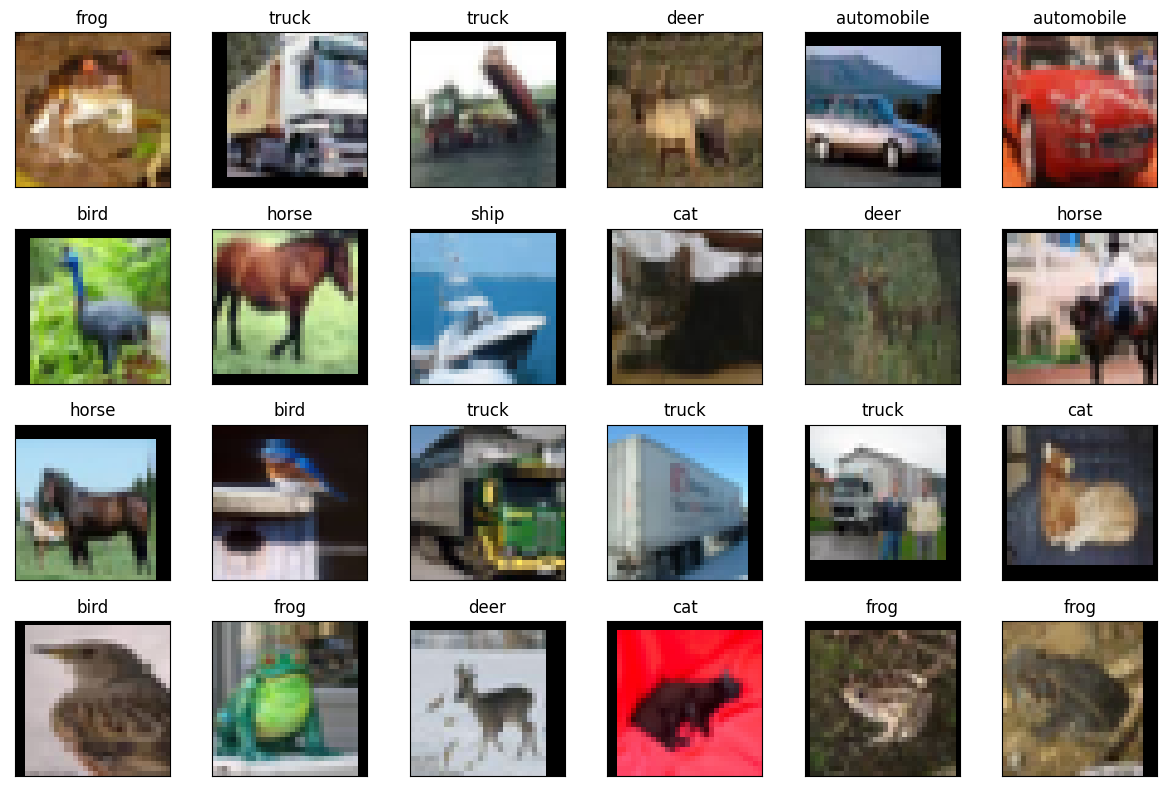

In [20]:
augment_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip()
])
augmented_train_data = CIFAR10(root='cifar10/train/', train=True, download=True,
                               transform=transforms.Compose([augment_transform, normalize_transform]))
visualize_dataset(augmented_train_data)

In [21]:
tanh_mlp = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=3072, out_features=512),
    nn.Tanh(),
    nn.Linear(in_features=512, out_features=10)
)
if USE_GPU:
    tanh_mlp.cuda()
    
opt = optim.Adam(tanh_mlp.parameters(), lr=2e-4)
train_classifier(tanh_mlp, opt, f'tanh_mlp_augmented', train_data=augmented_train_data)

Epoch 1 | train loss: 1.880, train accuracy: 0.333, test loss: 1.780, test accuracy: 0.380, time: 0:00:31
Epoch 2 | train loss: 1.751, train accuracy: 0.383, test loss: 1.753, test accuracy: 0.391, time: 0:01:03
Epoch 3 | train loss: 1.684, train accuracy: 0.406, test loss: 1.712, test accuracy: 0.409, time: 0:01:34
Epoch 4 | train loss: 1.639, train accuracy: 0.421, test loss: 1.691, test accuracy: 0.415, time: 0:02:06
Epoch 5 | train loss: 1.598, train accuracy: 0.434, test loss: 1.680, test accuracy: 0.420, time: 0:02:37
Epoch 6 | train loss: 1.570, train accuracy: 0.447, test loss: 1.659, test accuracy: 0.424, time: 0:03:09
Epoch 7 | train loss: 1.546, train accuracy: 0.454, test loss: 1.642, test accuracy: 0.428, time: 0:03:41
Epoch 8 | train loss: 1.518, train accuracy: 0.462, test loss: 1.620, test accuracy: 0.442, time: 0:04:12
Epoch 9 | train loss: 1.502, train accuracy: 0.470, test loss: 1.610, test accuracy: 0.443, time: 0:04:44
Epoch 10 | train loss: 1.485, train accuracy: 

Training and testing loss/accuracy are now much closer. Testing accuracy gets slightly better.


**Training MLP with the same architecture as above which uses ReLU instead of tanh as the activation.**

In [22]:
relu_mlp = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=3072, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10)
)
if USE_GPU:
    relu_mlp.cuda()

    
opt = optim.Adam(relu_mlp.parameters(), lr=2e-4)
train_classifier(relu_mlp, opt, 'relu_mlp', train_data=augmented_train_data)

Epoch 1 | train loss: 1.792, train accuracy: 0.363, test loss: 1.604, test accuracy: 0.438, time: 0:00:30
Epoch 2 | train loss: 1.632, train accuracy: 0.423, test loss: 1.521, test accuracy: 0.465, time: 0:01:01
Epoch 3 | train loss: 1.570, train accuracy: 0.447, test loss: 1.479, test accuracy: 0.486, time: 0:01:31
Epoch 4 | train loss: 1.526, train accuracy: 0.463, test loss: 1.448, test accuracy: 0.498, time: 0:02:02
Epoch 5 | train loss: 1.496, train accuracy: 0.472, test loss: 1.437, test accuracy: 0.498, time: 0:02:33
Epoch 6 | train loss: 1.476, train accuracy: 0.482, test loss: 1.424, test accuracy: 0.507, time: 0:03:04
Epoch 7 | train loss: 1.456, train accuracy: 0.486, test loss: 1.397, test accuracy: 0.512, time: 0:03:34
Epoch 8 | train loss: 1.436, train accuracy: 0.491, test loss: 1.393, test accuracy: 0.508, time: 0:04:05
Epoch 9 | train loss: 1.421, train accuracy: 0.498, test loss: 1.367, test accuracy: 0.522, time: 0:04:35
Epoch 10 | train loss: 1.409, train accuracy: 

The results again get a bit better. Due to the linear behaviour of ReLU for positive values, it has less issues with vanishing gradients.

**Building a simple Convolutional Neural Network (CNN)**

In [23]:
cnn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=4096, out_features=10)
)
if USE_GPU:
    cnn.cuda()

opt = optim.Adam(cnn.parameters(), lr=1e-3)
train_classifier(cnn, opt, 'cnn', train_data=augmented_train_data)

Epoch 1 | train loss: 1.553, train accuracy: 0.441, test loss: 1.226, test accuracy: 0.572, time: 0:01:01
Epoch 2 | train loss: 1.238, train accuracy: 0.562, test loss: 1.049, test accuracy: 0.635, time: 0:02:03
Epoch 3 | train loss: 1.102, train accuracy: 0.611, test loss: 0.943, test accuracy: 0.673, time: 0:03:05
Epoch 4 | train loss: 1.029, train accuracy: 0.640, test loss: 0.908, test accuracy: 0.682, time: 0:04:07
Epoch 5 | train loss: 0.981, train accuracy: 0.659, test loss: 0.896, test accuracy: 0.692, time: 0:05:09
Epoch 6 | train loss: 0.949, train accuracy: 0.668, test loss: 0.860, test accuracy: 0.703, time: 0:06:11
Epoch 7 | train loss: 0.923, train accuracy: 0.677, test loss: 0.904, test accuracy: 0.682, time: 0:07:14
Epoch 8 | train loss: 0.899, train accuracy: 0.686, test loss: 0.834, test accuracy: 0.711, time: 0:08:17
Epoch 9 | train loss: 0.874, train accuracy: 0.697, test loss: 0.784, test accuracy: 0.732, time: 0:09:19
Epoch 10 | train loss: 0.853, train accuracy: 

The accuracy improved significantly, but the training time increased.

**Batch Normalization**


In [24]:
cnn_batchnorm = nn.Sequential(
    
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=4096, out_features=10)
    
)
if USE_GPU:
    cnn_batchnorm.cuda()

opt = optim.Adam(cnn_batchnorm.parameters(), lr=1e-3)
train_classifier(cnn_batchnorm, opt, 'cnn_batchnorm', train_data=augmented_train_data)

Epoch 1 | train loss: 1.515, train accuracy: 0.462, test loss: 1.149, test accuracy: 0.579, time: 0:01:15
Epoch 2 | train loss: 1.158, train accuracy: 0.589, test loss: 1.014, test accuracy: 0.643, time: 0:02:28
Epoch 3 | train loss: 1.066, train accuracy: 0.624, test loss: 0.958, test accuracy: 0.673, time: 0:03:40
Epoch 4 | train loss: 0.993, train accuracy: 0.654, test loss: 0.873, test accuracy: 0.698, time: 0:04:53
Epoch 5 | train loss: 0.945, train accuracy: 0.673, test loss: 0.860, test accuracy: 0.702, time: 0:06:05
Epoch 6 | train loss: 0.915, train accuracy: 0.684, test loss: 0.913, test accuracy: 0.687, time: 0:07:18
Epoch 7 | train loss: 0.887, train accuracy: 0.691, test loss: 0.799, test accuracy: 0.725, time: 0:08:30
Epoch 8 | train loss: 0.860, train accuracy: 0.702, test loss: 0.858, test accuracy: 0.701, time: 0:09:43
Epoch 9 | train loss: 0.836, train accuracy: 0.712, test loss: 0.773, test accuracy: 0.736, time: 0:10:55
Epoch 10 | train loss: 0.816, train accuracy: 

**Strided Convolutions**



In [25]:
cnn_strides = nn.Sequential(
    
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=4096, out_features=10)
    
)
if USE_GPU:
    cnn_strides.cuda()

opt = optim.Adam(cnn_strides.parameters(), lr=1e-3)
train_classifier(cnn_strides, opt, 'cnn_strides', train_data=augmented_train_data)

Epoch 1 | train loss: 1.533, train accuracy: 0.448, test loss: 1.275, test accuracy: 0.535, time: 0:00:38
Epoch 2 | train loss: 1.270, train accuracy: 0.547, test loss: 1.140, test accuracy: 0.590, time: 0:01:16
Epoch 3 | train loss: 1.141, train accuracy: 0.598, test loss: 1.000, test accuracy: 0.649, time: 0:01:53
Epoch 4 | train loss: 1.078, train accuracy: 0.620, test loss: 0.943, test accuracy: 0.673, time: 0:02:32
Epoch 5 | train loss: 1.028, train accuracy: 0.638, test loss: 0.964, test accuracy: 0.666, time: 0:03:10
Epoch 6 | train loss: 0.995, train accuracy: 0.654, test loss: 0.928, test accuracy: 0.683, time: 0:03:48
Epoch 7 | train loss: 0.973, train accuracy: 0.658, test loss: 0.894, test accuracy: 0.683, time: 0:04:26
Epoch 8 | train loss: 0.949, train accuracy: 0.670, test loss: 0.874, test accuracy: 0.697, time: 0:05:05
Epoch 9 | train loss: 0.933, train accuracy: 0.675, test loss: 0.851, test accuracy: 0.703, time: 0:05:43
Epoch 10 | train loss: 0.913, train accuracy: 

Training is faster. For pooling with size 2 all four features have to be computed to get the max/mean of each window. For striding only a single feature per window has to be computed.

**Global Pooling**



In [26]:
class GlobalAvgPool2d(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        pooled = x.mean(dim=(2, 3))
        return pooled


cnn_global_pool = nn.Sequential(
    
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    GlobalAvgPool2d(),
    nn.Linear(in_features=64, out_features=10)
    
)
if USE_GPU:
    cnn_global_pool.cuda()

opt = optim.Adam(cnn_global_pool.parameters(), lr=1e-3)
train_classifier(cnn_global_pool, opt, 'cnn_global_pool', train_data=augmented_train_data)

Epoch 1 | train loss: 1.663, train accuracy: 0.400, test loss: 1.430, test accuracy: 0.484, time: 0:00:39
Epoch 2 | train loss: 1.376, train accuracy: 0.505, test loss: 1.301, test accuracy: 0.531, time: 0:01:18
Epoch 3 | train loss: 1.264, train accuracy: 0.547, test loss: 1.235, test accuracy: 0.551, time: 0:01:58
Epoch 4 | train loss: 1.196, train accuracy: 0.574, test loss: 1.192, test accuracy: 0.572, time: 0:02:37
Epoch 5 | train loss: 1.145, train accuracy: 0.591, test loss: 1.125, test accuracy: 0.600, time: 0:03:17
Epoch 6 | train loss: 1.105, train accuracy: 0.607, test loss: 1.094, test accuracy: 0.607, time: 0:03:56
Epoch 7 | train loss: 1.074, train accuracy: 0.618, test loss: 1.041, test accuracy: 0.625, time: 0:04:36
Epoch 8 | train loss: 1.049, train accuracy: 0.627, test loss: 1.012, test accuracy: 0.637, time: 0:05:15
Epoch 9 | train loss: 1.019, train accuracy: 0.640, test loss: 0.990, test accuracy: 0.645, time: 0:05:55
Epoch 10 | train loss: 1.001, train accuracy: 

**Residual Networks**



In [27]:
class ResNetBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.activation = nn.ReLU()
        self.pad_weight = nn.Parameter(
            torch.eye(out_channels, in_channels)[:, :, None, None],
            requires_grad=False
        )
        self.stride = stride

    def forward(self, x):
        r = self.f(x)
        x = F.conv2d(x, self.pad_weight, stride=self.stride)
        return self.activation(x + r)
    

class ResNet(torch.nn.Module):
    def __init__(self, num_layers=14, in_channels=3, out_features=10):
        super().__init__()
        if (num_layers - 2) % 6 != 0:
            raise ValueError('n_layers should be 6n+2 (eg 20, 32, 44, 56)')
        n = (num_layers - 2) // 6
        
        layers = []
        
        first_layer = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        
        layers.append(first_layer)

        for i in range(n):
            layers.append(ResNetBlock(16, 16))

        layers.append(ResNetBlock(16, 32, stride=2))
        for i in range(1, n):
            layers.append(ResNetBlock(32, 32))

        layers.append(ResNetBlock(32, 64, stride=2))
        for i in range(1, n):
            layers.append(ResNetBlock(64, 64))
            
        layers.append(GlobalAvgPool2d())
        layers.append(nn.Linear(64, out_features))
        
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [28]:
resnet = ResNet()
if USE_GPU:
    resnet.cuda()

opt = optim.Adam(resnet.parameters(), lr=1e-3, weight_decay=1e-4)
train_classifier(resnet, opt, f'resnet', train_data=augmented_train_data)

Epoch 1 | train loss: 1.481, train accuracy: 0.457, test loss: 1.237, test accuracy: 0.549, time: 0:02:24
Epoch 2 | train loss: 1.084, train accuracy: 0.612, test loss: 1.071, test accuracy: 0.623, time: 0:04:49
Epoch 3 | train loss: 0.931, train accuracy: 0.667, test loss: 1.031, test accuracy: 0.639, time: 0:07:14
Epoch 4 | train loss: 0.835, train accuracy: 0.706, test loss: 0.859, test accuracy: 0.700, time: 0:09:39
Epoch 5 | train loss: 0.755, train accuracy: 0.733, test loss: 0.913, test accuracy: 0.695, time: 0:12:06
Epoch 6 | train loss: 0.693, train accuracy: 0.758, test loss: 0.730, test accuracy: 0.752, time: 0:14:31
Epoch 7 | train loss: 0.646, train accuracy: 0.776, test loss: 0.719, test accuracy: 0.748, time: 0:16:56
Epoch 8 | train loss: 0.609, train accuracy: 0.788, test loss: 0.682, test accuracy: 0.761, time: 0:19:21
Epoch 9 | train loss: 0.585, train accuracy: 0.798, test loss: 0.615, test accuracy: 0.791, time: 0:21:46
Epoch 10 | train loss: 0.556, train accuracy: 

**Learning Rate Decay**

Learning rate decay reduces the learning rate as the training progresses. Use the same settings as in the previous experiment, but this time create a `MultiStepLR`-scheduler and decrease the learning rate twice by a factor of 10 each.

In [29]:
resnet_decay = ResNet()
if USE_GPU:
    resnet_decay.cuda()

opt = optim.Adam(resnet_decay.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(opt, [35, 45], gamma=0.1)
train_classifier(resnet_decay, opt, 'resnet_decay', lr_scheduler=scheduler, train_data=augmented_train_data)

Epoch 1 | train loss: 1.468, train accuracy: 0.465, test loss: 1.246, test accuracy: 0.537, time: 0:02:24
Epoch 2 | train loss: 1.070, train accuracy: 0.616, test loss: 1.051, test accuracy: 0.623, time: 0:04:48
Epoch 3 | train loss: 0.912, train accuracy: 0.676, test loss: 0.952, test accuracy: 0.669, time: 0:07:13
Epoch 4 | train loss: 0.814, train accuracy: 0.714, test loss: 0.978, test accuracy: 0.669, time: 0:09:37
Epoch 5 | train loss: 0.735, train accuracy: 0.741, test loss: 0.792, test accuracy: 0.723, time: 0:12:17
Epoch 6 | train loss: 0.678, train accuracy: 0.761, test loss: 0.786, test accuracy: 0.734, time: 0:14:41
Epoch 7 | train loss: 0.635, train accuracy: 0.779, test loss: 0.663, test accuracy: 0.775, time: 0:17:05
Epoch 8 | train loss: 0.601, train accuracy: 0.791, test loss: 0.618, test accuracy: 0.785, time: 0:19:29
Epoch 9 | train loss: 0.570, train accuracy: 0.800, test loss: 0.675, test accuracy: 0.773, time: 0:21:54
Epoch 10 | train loss: 0.549, train accuracy: 